# FloPy

## MODPATH 7 DISV unstructured model example

This is a replication of the MODPATH Problem 2 example that is described on page 12 of the modpath_7_examples.pdf file.  The results shown here should be the same as the results in the MODPATH example, however, the vertex and node numbering used here may be different from the numbering used in MODPATH, so head values may not be compared directly without some additional mapping.

## Part I. Setup Notebook

In [1]:
import sys
import os
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

    print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

# temporary directory
temp_dir = TemporaryDirectory()
workspace = temp_dir.name

numpy version: 1.23.1
matplotlib version: 3.5.2
flopy version: 3.3.6


## Part II. Gridgen Creation of Model Grid

In [2]:
from flopy.utils.gridgen import Gridgen

### Create the Base MODFLOW Grid

In [3]:
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

In [4]:
ms = flopy.modflow.Modflow()
dis5 = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

### Create the Gridgen Object

In [5]:
model_name = "mp7p2_u"
model_ws = os.path.join(workspace, "mp7_ex2", "mf6")
gridgen_ws = os.path.join(model_ws, "gridgen")
g = Gridgen(dis5, model_ws=gridgen_ws)

### Refine the Grid

In [6]:
rf0shp = os.path.join(gridgen_ws, "rf0")
xmin = 7 * delr
xmax = 12 * delr
ymin = 8 * delc
ymax = 13 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 1, range(nlay))

rf1shp = os.path.join(gridgen_ws, "rf1")
xmin = 8 * delr
xmax = 11 * delr
ymin = 9 * delc
ymax = 12 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 2, range(nlay))

rf2shp = os.path.join(gridgen_ws, "rf2")
xmin = 9 * delr
xmax = 10 * delr
ymin = 10 * delc
ymax = 11 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 3, range(nlay))

/Users/wes/dev/flopy/venv/lib/python3.10/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


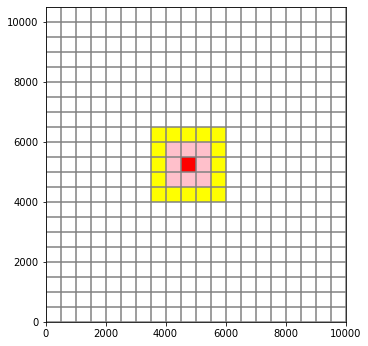

In [7]:
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor="yellow", edgecolor="none")
flopy.plot.plot_shapefile(rf1shp, ax=ax, facecolor="pink", edgecolor="none")
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor="red", edgecolor="none");

In [8]:
g.build(verbose=False)

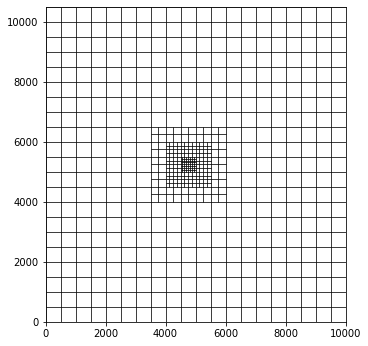

In [9]:
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
g.plot(ax, linewidth=0.5);

### Extract the Grid Properties

In [10]:
gridprops = g.get_gridprops_disv()
# gridprops

In [11]:
ncpl = gridprops["ncpl"]
top = gridprops["top"]
botm = gridprops["botm"]
nvert = gridprops["nvert"]
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]

## Part III. Create the Flopy Model

In [12]:
# create simulation
sim = flopy.mf6.MFSimulation(
    sim_name=model_name, version="mf6", exe_name="mf6", sim_ws=model_ws
)

# create tdis package
tdis_rc = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc
)

# create gwf model
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=model_name, model_nam_file="{}.nam".format(model_name)
)
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    print_option="SUMMARY",
    complexity="SIMPLE",
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)
sim.register_ims_package(ims, [gwf.name])

# disv
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl,
    top=top,
    botm=botm,
    nvert=nvert,
    vertices=vertices,
    cell2d=cell2d,
)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=320.0)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=[("xt3d")],
    icelltype=[1, 0, 0],
    k=[50.0, 0.01, 200.0],
    k33=[10.0, 0.01, 20.0],
)

# wel
wellpoints = [(4750.0, 5250.0)]
welcells = g.intersect(wellpoints, "point", 0)
# welspd = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=1, aux_vars=['iface'])
welspd = [[(2, icpl), -150000, 0] for icpl in welcells["nodenumber"]]
wel = flopy.mf6.ModflowGwfwel(
    gwf, print_input=True, auxiliary=[("iface",)], stress_period_data=welspd
)

# rch
aux = [np.ones(ncpl, dtype=int) * 6]
rch = flopy.mf6.ModflowGwfrcha(
    gwf, recharge=0.005, auxiliary=[("iface",)], aux={0: [6]}
)
# riv
riverline = [[(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]]
rivcells = g.intersect(riverline, "line", 0)
rivspd = [[(0, icpl), 320.0, 100000.0, 318] for icpl in rivcells["nodenumber"]]
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord="{}.cbb".format(model_name),
    head_filerecord="{}.hds".format(model_name),
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mp7p2_u...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...


## Part IV. Run the MODFLOW 6 Model

In [13]:
sim.run_simulation()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S.

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:32:59
 Elapsed run time:  0.087 Seconds
 
 Normal termination of simulation.


(True, [])

## Part V. Import and Plot the Results

### Plot the Boundary Locations

In [14]:
fname = os.path.join(model_ws, model_name + ".disv.grb")
grd = flopy.mf6.utils.MfGrdFile(fname, verbose=False)
mg = grd.modelgrid

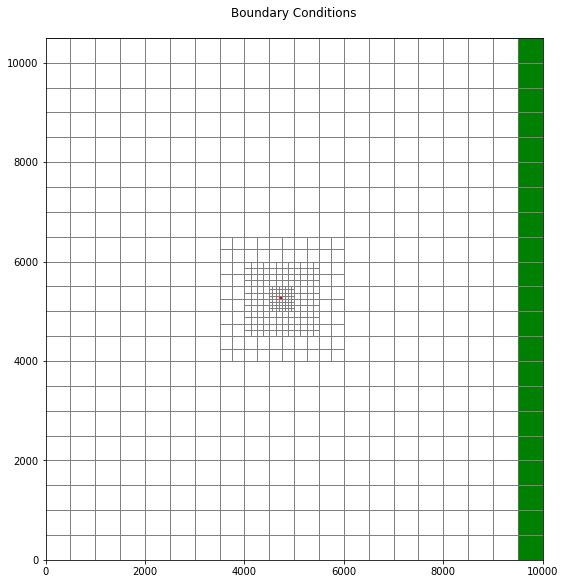

In [15]:
ibd = np.zeros((ncpl), dtype=int)
ibd[welcells["nodenumber"]] = 1
ibd[rivcells["nodenumber"]] = 2
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
pc = pmv.plot_array(ibd, cmap=cmap, edgecolor="gray")
t = ax.set_title("Boundary Conditions\n");

In [16]:
fname = os.path.join(model_ws, model_name + ".hds")
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
head.shape

(3, 1, 651)

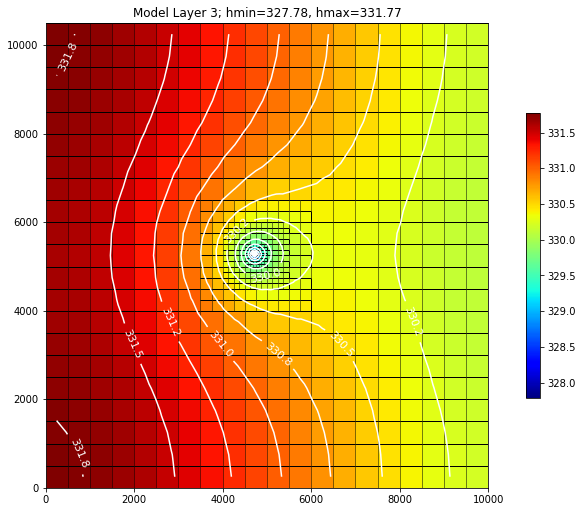

In [17]:
ilay = 2
cint = 0.25
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax, layer=ilay)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
pc = mm.plot_array(head[:, 0, :], cmap="jet", edgecolor="black")
hmin = head[ilay, 0, :].min()
hmax = head[ilay, 0, :].max()
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[:, 0, :], colors="white", levels=levels)
plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)
cb = plt.colorbar(pc, shrink=0.5)
t = ax.set_title(
    "Model Layer {}; hmin={:6.2f}, hmax={:6.2f}".format(ilay + 1, hmin, hmax)
);

### Model Cells and Vertices

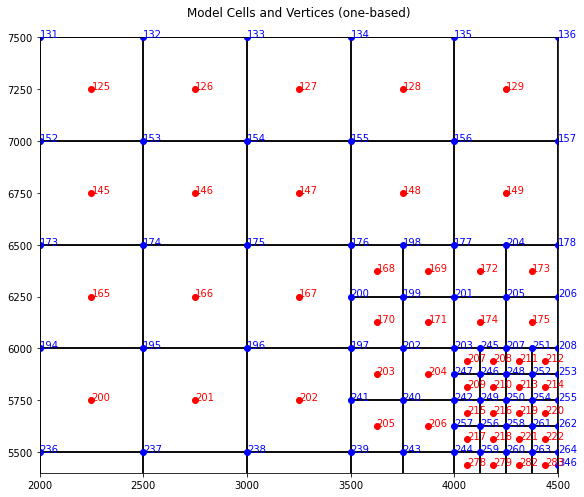

In [18]:
# zoom area
xmin, xmax = 2000, 4500
ymin, ymax = 5400, 7500

mg.get_cell_vertices
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
v = mm.plot_grid(edgecolor="black")
t = ax.set_title("Model Cells and Vertices (one-based)\n")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

verts = mg.verts
ax.plot(verts[:, 0], verts[:, 1], "bo")
for i in range(ncpl):
    x, y = verts[i, 0], verts[i, 1]
    if xmin <= x <= xmax and ymin <= y <= ymax:
        ax.annotate(str(i + 1), verts[i, :], color="b")

xc, yc = mg.get_xcellcenters_for_layer(0), mg.get_ycellcenters_for_layer(0)
for i in range(ncpl):
    x, y = xc[i], yc[i]
    ax.plot(x, y, "ro")
    if xmin <= x <= xmax and ymin <= y <= ymax:
        ax.annotate(str(i + 1), (x, y), color="r")

## Part VI. Create the Flopy MODPATH7 Models

### Define names for the MODPATH 7 simulations

In [19]:
mp_namea = model_name + "a_mp"
mp_nameb = model_name + "b_mp"

### Create the particles

Create particles for the pathline and timeseries analysis

In [20]:
pcoord = np.array(
    [
        [0.000, 0.125, 0.500],
        [0.000, 0.375, 0.500],
        [0.000, 0.625, 0.500],
        [0.000, 0.875, 0.500],
        [1.000, 0.125, 0.500],
        [1.000, 0.375, 0.500],
        [1.000, 0.625, 0.500],
        [1.000, 0.875, 0.500],
        [0.125, 0.000, 0.500],
        [0.375, 0.000, 0.500],
        [0.625, 0.000, 0.500],
        [0.875, 0.000, 0.500],
        [0.125, 1.000, 0.500],
        [0.375, 1.000, 0.500],
        [0.625, 1.000, 0.500],
        [0.875, 1.000, 0.500],
    ]
)
nodew = gwf.disv.ncpl.array * 2 + welcells["nodenumber"][0]
plocs = [nodew for i in range(pcoord.shape[0])]

# create particle data
pa = flopy.modpath.ParticleData(
    plocs,
    structured=False,
    localx=pcoord[:, 0],
    localy=pcoord[:, 1],
    localz=pcoord[:, 2],
    drape=0,
)

# create backward particle group
fpth = mp_namea + ".sloc"
pga = flopy.modpath.ParticleGroup(
    particlegroupname="BACKWARD1", particledata=pa, filename=fpth
)

Create particles for endpoint analysis

In [21]:
facedata = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=10,
    horizontaldivisions1=10,
    verticaldivisions2=10,
    horizontaldivisions2=10,
    verticaldivisions3=10,
    horizontaldivisions3=10,
    verticaldivisions4=10,
    horizontaldivisions4=10,
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=4,
    columndivisions6=4,
)
pb = flopy.modpath.NodeParticleData(subdivisiondata=facedata, nodes=nodew)
# create forward particle group
fpth = mp_nameb + ".sloc"
pgb = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="BACKWARD2", particledata=pb, filename=fpth
)

### Create and run the pathline and timeseries analysis model

In [22]:
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_namea, flowmodel=gwf, exe_name="mp7", model_ws=model_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=0.1)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=pga,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
        16 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

### Load the pathline  and timeseries data

In [23]:
fpth = os.path.join(model_ws, mp_namea + ".mppth")
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()

In [24]:
fpth = os.path.join(model_ws, mp_namea + ".timeseries")
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

### Plot the pathline and timeseries data

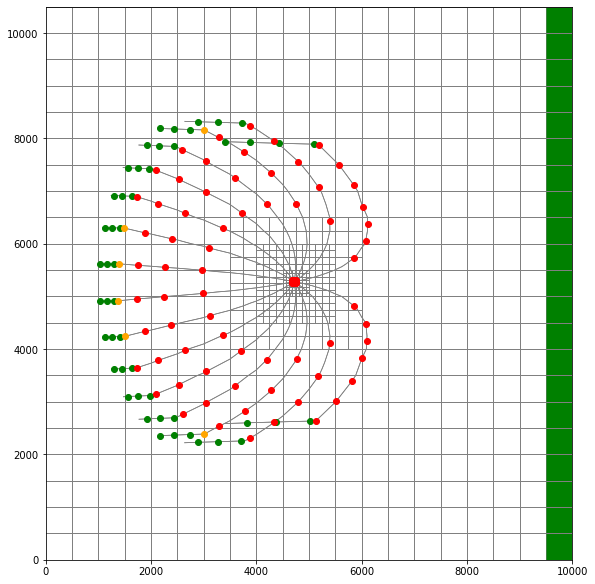

In [25]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(ibd, cmap=cmap, edgecolor="gray")
mm.plot_pathline(p0, layer="all", color="blue", lw=0.75)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k]);

### Create and run the endpoint analysis model

In [26]:
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_nameb, flowmodel=gwf, exe_name="mp7", model_ws=model_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=0.1)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="endpoint",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    particlegroups=pgb,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
       416 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

### Load the endpoint data

In [27]:
fpth = os.path.join(model_ws, mp_nameb + ".mpend")
e = flopy.utils.EndpointFile(fpth)
e0 = e.get_alldata()

### Plot the endpoint data

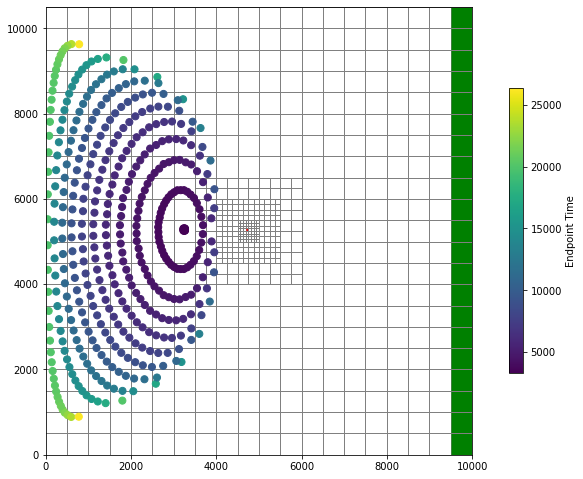

In [28]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(ibd, cmap=cmap, edgecolor="gray")
mm.plot_endpoint(e0, direction="ending", colorbar=True, shrink=0.5);

In [29]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass